# Calculating band indices <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Acknowledgement**: This notebook was originally created by [Digital Earth Australia (DEA)](https://www.ga.gov.au/about/projects/geographic/digital-earth-australia) and has been modified for use in the EY Data Science Program
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)


## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
Using Digital Earth Australia's archive of analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms.


## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculate_indices` from `dea_bandindices.py`
* Calculate indices while dropping original bands from a dataset
* Calculate an index in-place without duplicating original data to save memory on large datasets
 
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append('../scripts')
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Calculating_band_indices')

## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. 
We will use data from the Landsat 8 satellite:

In [3]:
# Set location
lat_range = (-38.64, -38.66)
lon_range = (145.700, 145.745)
time_range = ('2018', '2020')
time_step = '3M'

# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': [
        'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
        'nbart_swir_2'
    ],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, products=['ga_ls8c_ard_3'], min_gooddata=0.90, **query)


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 8 out of 30 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 8 time steps


### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image:

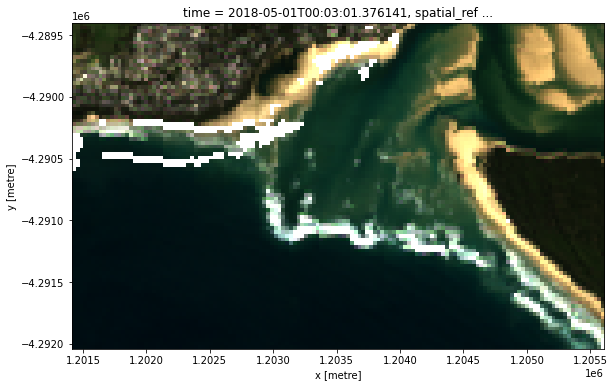

In [4]:
# Plot as an RGB image
rgb(ds, index=0)


## Calculate an index for this area manually
One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. 
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation.
The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.

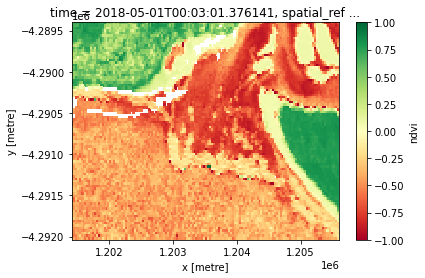

In [5]:
# Calculate NDVI using the formula above
ds['ndvi'] = (ds.nbart_nir - ds.nbart_red) / (ds.nbart_nir + ds.nbart_red)

# Plot the results for one time step to see what they look like:
ds.ndvi.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')


In the image above, vegetation shows up as green (NDVI > 0). 
Sand shows up as yellow (NDVI ~ 0) and water shows up as red (NDVI < 0).

## Calculate an index for the same area using `calculate_indices` function

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- **AWEI_ns** (Automated Water Extraction Index,no shadows, Feyisa 2014)
- **AWEI_sh** (Automated Water Extraction Index,shadows, Feyisa 2014)
- **BAEI**    (Built-Up Area Extraction Index, Bouzekri et al. 2015) 
- **BAI**     (Burn Area Index, Martin 1998)
- **BSI**     (Bare Soil Index, Rikimaru et al. 2002)
- **BUI**     (Built-Up Index, He et al. 2010)
- **CMR**     (Clay Minerals Ratio, Drury 1987)
- **EVI**     (Enhanced Vegetation Index, Huete 2002)
- **FMR**     (Ferrous Minerals Ratio, Segal 1982)
- **IOR**     (Iron Oxide Ratio, Segal 1982)  
- **LAI**     (Leaf Area Index, Boegh 2002)
- **MNDWI**   (Modified Normalised Difference Water Index, Xu 1996) 
- **MSAVI**   (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)              
- **NBI**     (New Built-Up Index, Jieli et al. 2010)
- **NBR**     (Normalised Burn Ratio, Lopez Garcia 1991)
- **NDBI**    (Normalised Difference Built-Up Index, Zha 2003)
- **NDCI**    (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)
- **NDMI**    (Normalised Difference Moisture Index, Gao 1996)        
- **NDSI**    (Normalised Difference Snow Index, Hall 1995)
- **NDVI**    (Normalised Difference Vegetation Index, Rouse 1973)
- **NDWI**    (Normalised Difference Water Index, McFeeters 1996)
- **SAVI**    (Soil Adjusted Vegetation Index, Huete 1988)
- **TCB**     (Tasseled Cap Brightness, Crist 1985)
- **TCG**     (Tasseled Cap Greeness, Crist 1985)
- **TCW**     (Tasseled Cap Wetness, Crist 1985)
- **WI**      (Water Index, Fisher 2016) 

### Using `calculate_indices`, we get the same result:

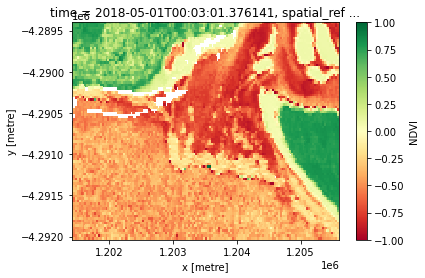

In [6]:
# Calculate NDVI using `calculate indices`
ds_ndvi = calculate_indices(ds, index='NDVI', collection='ga_ls_3')

# Plot the results 
ds_ndvi.NDVI.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')


> **Note**: when using the `calculate_indices` function, it is important to set the `collection` parameter correctly. 
This is because different satellite collections use different names for the same bands, which can lead to invalid results if not accounted for. 
For Landsat (i.e. GA Landsat Collection 3), specify `collection='ga_ls_3'`. 
For Sentinel 2 (i.e. GA Sentinel 2 Collection 1), specify `collection='ga_s2_1'`.

### Using calculate_indices to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Modified Normalised Difference Index (`MNDWI`).
The new indices will appear in the list of `data_variables` below:

In [7]:
# Calculate multiple indices
ds_multi = calculate_indices(ds, index=['NDVI', 'NDWI', 'MNDWI'], collection='ga_ls_3')
print(ds_multi)


<xarray.Dataset>
Dimensions:       (time: 8, x: 140, y: 88)
Coordinates:
  * time          (time) datetime64[ns] 2018-05-01T00:03:01.376141 ... 2019-0...
  * y             (y) float64 -4.289e+06 -4.289e+06 ... -4.292e+06 -4.292e+06
  * x             (x) float64 1.201e+06 1.201e+06 ... 1.206e+06 1.206e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 346.0 339.0 251.0 ... 476.0 450.0 2210.0
    nbart_green   (time, y, x) float32 690.0 673.0 498.0 ... 529.0 484.0 2588.0
    nbart_red     (time, y, x) float32 564.0 547.0 425.0 ... 152.0 178.0 2240.0
    nbart_nir     (time, y, x) float32 3284.0 3174.0 2519.0 ... 81.0 42.0 1773.0
    nbart_swir_1  (time, y, x) float32 2553.0 2490.0 1949.0 ... 60.0 62.0 425.0
    nbart_swir_2  (time, y, x) float32 1439.0 1420.0 988.0 ... 41.0 45.0 222.0
    ndvi          (time, y, x) float32 0.7068607 0.705993 ... -0.11637179
    NDVI          (time, y, x) float32 0.7068607 0.70599306 ... -0.11637179
    NDWI          (

### Dropping original bands from a dataset
We can also drop the original satellite bands from the dataset using `drop=True`. 
The dataset produced below should now only include the new `'NDVI', 'NDWI', 'MNDWI'` bands under `data_variables`:

In [8]:
# Calculate multiple indices and drop original bands
ds_drop = calculate_indices(ds, 
                            index=['NDVI', 'NDWI', 'MNDWI'], 
                            drop=True, 
                            collection='ga_ls_3')
print(ds_drop)


Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'ndvi']
<xarray.Dataset>
Dimensions:      (time: 8, x: 140, y: 88)
Coordinates:
  * time         (time) datetime64[ns] 2018-05-01T00:03:01.376141 ... 2019-04...
  * y            (y) float64 -4.289e+06 -4.289e+06 ... -4.292e+06 -4.292e+06
  * x            (x) float64 1.201e+06 1.201e+06 ... 1.206e+06 1.206e+06
    spatial_ref  int32 3577
Data variables:
    NDVI         (time, y, x) float32 0.7068607 0.70599306 ... -0.11637179
    NDWI         (time, y, x) float32 -0.6527428 -0.65011704 ... 0.18688373
    MNDWI        (time, y, x) float32 -0.574468 -0.5744546 ... 0.71788913
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


### Calculating indices in-place to reduce memory usage for large datasets
By default, the `calculate_indices` function will create a new copy of the original data that contains the newly generated remote sensing indices.
This can be problematic for large datasets, as this effectively doubles the amount of data that is stored in memory.

To calculate remote sensing indices directly in-place within the original dataset without copying the data, we can run the function with the parameter `inplace=True`. 
Note that we don't need to assign any output for the function, as the changes will be made to the original data.

In [9]:
# Calculate index in place without copying data
calculate_indices(ds, 
                  index=['TCW'], 
                  collection='ga_ls_3', 
                  inplace=True)
print(ds)

<xarray.Dataset>
Dimensions:       (time: 8, x: 140, y: 88)
Coordinates:
  * time          (time) datetime64[ns] 2018-05-01T00:03:01.376141 ... 2019-0...
  * y             (y) float64 -4.289e+06 -4.289e+06 ... -4.292e+06 -4.292e+06
  * x             (x) float64 1.201e+06 1.201e+06 ... 1.206e+06 1.206e+06
    spatial_ref   int32 3577
Data variables:
    nbart_blue    (time, y, x) float32 346.0 339.0 251.0 ... 476.0 450.0 2210.0
    nbart_green   (time, y, x) float32 690.0 673.0 498.0 ... 529.0 484.0 2588.0
    nbart_red     (time, y, x) float32 564.0 547.0 425.0 ... 152.0 178.0 2240.0
    nbart_nir     (time, y, x) float32 3284.0 3174.0 2519.0 ... 81.0 42.0 1773.0
    nbart_swir_1  (time, y, x) float32 2553.0 2490.0 1949.0 ... 60.0 62.0 425.0
    nbart_swir_2  (time, y, x) float32 1439.0 1420.0 988.0 ... 41.0 45.0 222.0
    ndvi          (time, y, x) float32 0.7068607 0.705993 ... -0.11637179
    TCW           (time, y, x) float32 -0.17678863 -0.17398652 ... 0.11452393
Attributes:
    c

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question in the [Troubleshooting EY Data Science Program MS Teams Channel](https://teams.microsoft.com/l/channel/19%3a90804a73cb5a4159a60693c41a8820d2%40thread.tacv2/Troubleshooting?groupId=f6acd945-fed9-4db4-bed8-414988473a36&tenantId=5b973f99-77df-4beb-b27d-aa0c70b8482c) or on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2021

In [10]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5
